In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split

import shap

# INTRODUZIONE

Il Wine Quality è un dataset presente nella UCI machine learning repository.

Le varie features che lo compongono sono i risultati di test chimico-fisici e sensoriali effettuati su campioni di "vinho verde", un vino rosso del portogallo, volti a determinarne la qualità. 

I vini vengono infatti divisi, tramite l' attributo 'quality' in 10 classi (da 1 a 10), ciascuna delle quali rappresenta un diverso grado di eccellenza. Tanto più alto è il numero della classe di appartenza di un campione di vino e tanto maggiore è il suo valore.

# IMPORTAZIONE DATABASE REDWINE

Si inizia con l' importare il database, convertendolo da csv a pandas dataframe

In [44]:
red_wine = pd.read_csv('../data/cleaned/winequality-red.csv', sep=';')
red_wine = red_wine.apply(pd.to_numeric) # convert all columns of DataFrame
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Si procede con il controllo della distribuzione della colonna 'quality'. A tale scopo, viene generata una palette personalizzata composta da sfumature di arancione per segnalare i campioni di vino al di sotto della media, e sfumature di verde per identificare i vini di qualità superiore.

,counts,freq.
class,,
3,10,0.006254
4,53,0.033146
5,681,0.425891
6,638,0.398999
7,199,0.124453
8,18,0.011257


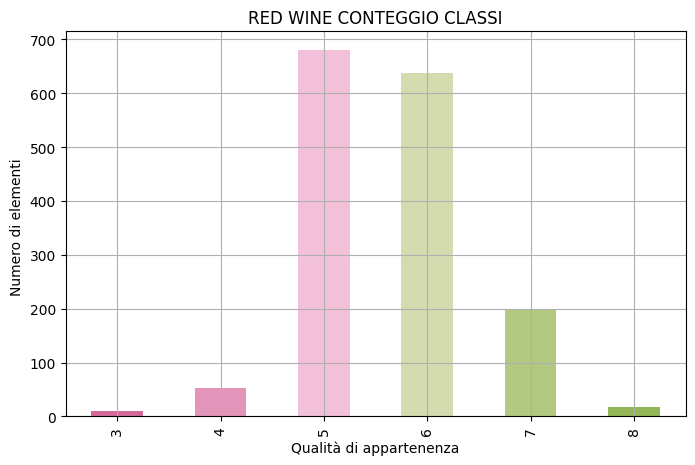

In [46]:
# Si selezionano delle tonalità di rosso e verde colorblind friendly
red_color = '#b51963'
green_color = '#5ba300'

# Tramite light_palette si creano sfumature dei colori selezionati che vengono manualmente 
# modificate per aumentarne la luminosità ed evitare colori troppo chiari
red_palette = sns.light_palette(red_color, n_colors=5, reverse=True)
red_palette = [(c[0], c[1]*0.8, c[2]*0.9) for c in red_palette]
green_palette = sns.light_palette(green_color, n_colors=5)
green_palette = [(c[0] * 0.9, c[1]*0.9, c[2] * 0.75) for c in green_palette]
custom_palette = red_palette + green_palette

# Si procede con il selezionare i valori unici della colonna 'quality' e creare un dizionario per i colori
quality_unique_values = np.unique(red_wine['quality'].values)
colors_mapping = dict(zip(np.arange(10)+1, custom_palette))

# Creazione di un dataset contenente i conteggi dei diversi livelli di qualità dei vari campioni e le loro frequenze
N = red_wine.shape[0]
class_cont_freq = pd.concat([red_wine['quality'].value_counts(), red_wine['quality'].value_counts() / N], axis=1)
class_cont_freq.columns = ['counts', 'freq.']  
class_cont_freq.index.name = 'class'
class_cont_freq.sort_values('class', inplace=True)
display(class_cont_freq)

# Un plot per mostrare la distribuzione della qualità dei vini, utilizzando la palette personalizzata
plt.figure()
class_cont_freq['counts'].plot.bar(figsize=(8, 5), color=[colors_mapping[q] for q in class_cont_freq.index])
plt.title('RED WINE CONTEGGIO CLASSI')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()
plt.show()

# PROBLEMA BINARIO

Ho diviso il problema di multiclassificazione in un problema binario accorpando le classi.

In [48]:
red_wine['quality'].replace([3, 4, 5], value=0, inplace=True)
red_wine['quality'].replace([6, 7, 8], value=1, inplace=True)

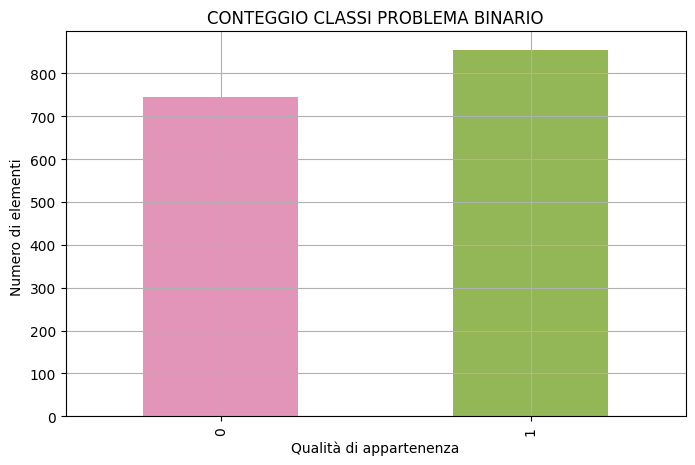

In [49]:
plt.figure()
red_wine['quality'].value_counts().sort_values().plot.bar(figsize=(8,5), color=[custom_palette[3], custom_palette[7]])
plt.title('CONTEGGIO CLASSI PROBLEMA BINARIO')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()

# PCA

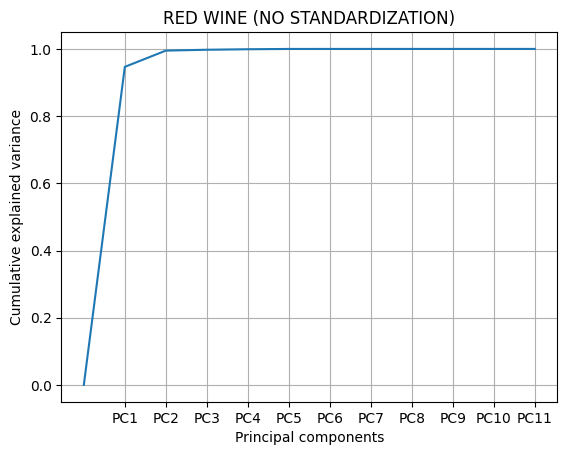

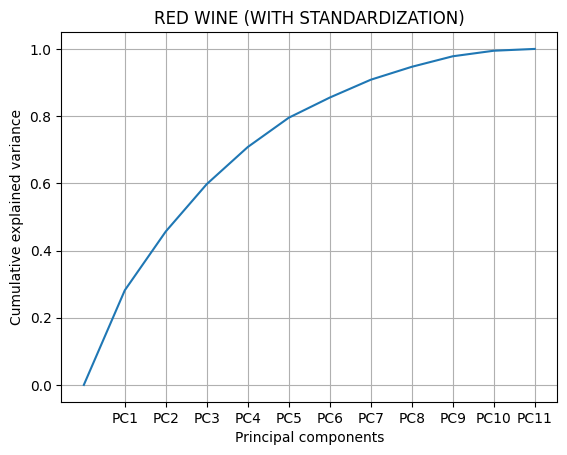

In [52]:
X_redwine = red_wine.iloc[:, :-1]  
scaler_redwine = StandardScaler().set_output(transform="pandas")
scaler_redwine.fit(X_redwine)

X_redwine_scaled = scaler_redwine.transform(X_redwine)

pca_redwine_nostd = PCA()
pca_redwine = PCA()

pca_redwine_nostd.fit(X_redwine)
pca_redwine.fit(X_redwine_scaled)

plt.figure()
plt.plot(np.insert(np.cumsum(pca_redwine_nostd.explained_variance_ratio_), 0, 0))
plt.title('RED WINE (NO STANDARDIZATION)')
plt.xticks(ticks=np.arange(1, pca_redwine_nostd.n_features_in_ + 1), 
           labels=[f'PC{i}' for i in range(1, pca_redwine_nostd.n_features_in_ + 1)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

plt.figure()
plt.plot(np.insert(np.cumsum(pca_redwine.explained_variance_ratio_), 0, 0))
plt.title('RED WINE (WITH STANDARDIZATION)')
plt.xticks(ticks=np.arange(1, pca_redwine.n_features_in_ + 1), 
           labels=[f'PC{i}' for i in range(1, pca_redwine.n_features_in_ + 1)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

In [53]:
X_redwine_scaled

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217796,0.403229,-0.980669,-0.382271,0.053845,1.542054,-0.075043,-0.978765,0.899886,-0.461180,0.072294
1595,-1.390155,0.123905,-0.877968,-0.240375,-0.541259,2.211469,0.137820,-0.862162,1.353436,0.601055,0.729364
1596,-1.160343,-0.099554,-0.723916,-0.169427,-0.243707,1.255161,-0.196679,-0.533554,0.705508,0.542042,0.541630
1597,-1.390155,0.654620,-0.775267,-0.382271,-0.264960,1.542054,-0.075043,-0.676657,1.677400,0.305990,-0.209308


# SCORE GRAPH

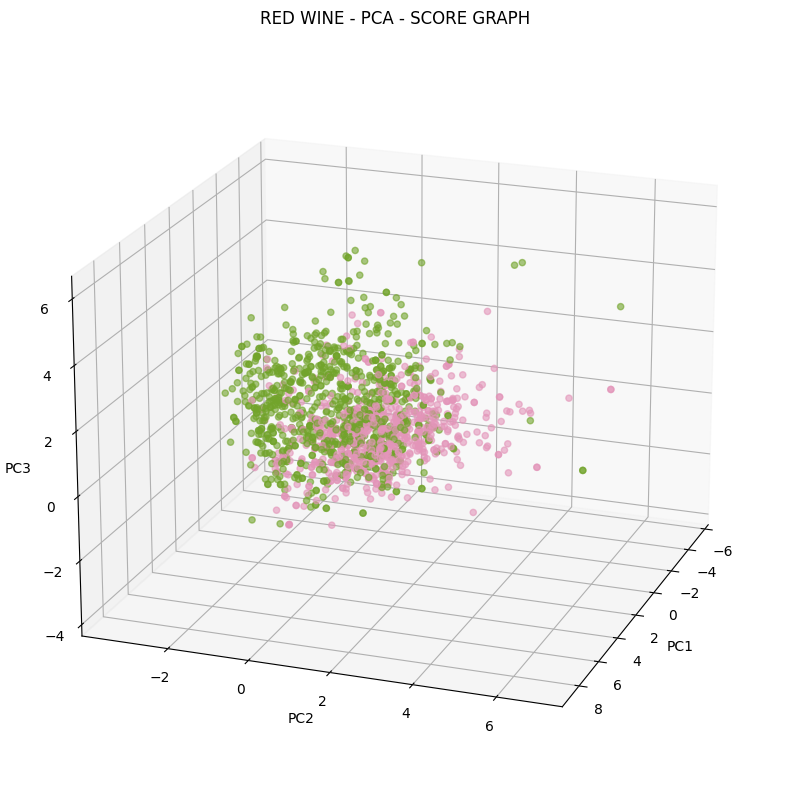

In [54]:
pca_redwine = PCA(n_components=3)

pca_redwine.fit(X_redwine_scaled)

Z3p_redwine = pca_redwine.transform(X_redwine_scaled)
fig_pca_winescore = plt.figure(figsize=(25,10)) 

colors_mapping = {0: custom_palette[3], 1: custom_palette[8]}


ax1 = fig_pca_winescore.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(Z3p_redwine[:, 0], Z3p_redwine[:, 1], Z3p_redwine[:, 2], c=[colors_mapping[val] for val in red_wine['quality']], alpha=0.6)
plt.title('RED WINE - PCA - SCORE GRAPH')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2') 
ax1.set_zlabel('PC3')
ax1.view_init(elev=20, azim=20)


# CREAZIONE TRAINING, VALIDATION E TEST SET

In [56]:
X = X_redwine
y = red_wine['quality']
y_nomi_classe = ['classe 0', 'classe 1']

random_state = 20210526
test_p = 0.5
val_p = 0.4
indices = np.arange(X.shape[0])

ind_train, ind_test = train_test_split(indices, test_size=test_p, random_state=random_state, shuffle=True)
ind_train, ind_val = train_test_split(ind_train, test_size=val_p, random_state=random_state, shuffle=True)

# GRID SEARCH

In [58]:
from sklearn.preprocessing import StandardScaler
import shap

n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler().set_output(transform="pandas")),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]), verbose=True)

svm_gs.fit(X_redwine, red_wine['quality'])



Fitting 1 folds for each of 60 candidates, totalling 60 fits


GridSearchCV(cv=<zip object at 0x000001F3D0ABA540>,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             param_grid={'svc__C': [0.25, 0.5, 1, 2, 4],
                         'svc__gamma': [0.18181818181818182,
                                        0.09090909090909091,
                                        0.06060606060606061],
                         'svc__kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             return_train_score=True, scoring='f1_weighted', verbose=True)

In [59]:
df_results = pd.DataFrame(svm_gs.cv_results_)

display(df_results.sort_values(['rank_test_score'], ascending=True))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
40,0.051087,0.0,0.017560,0.0,2,0.090909,rbf,"{'svc__C': 2, 'svc__gamma': 0.0909090909090909...",0.768497,0.768497,0.0,1,0.834984,0.834984,0.0
24,0.058978,0.0,0.029902,0.0,1,0.181818,rbf,"{'svc__C': 1, 'svc__gamma': 0.1818181818181818...",0.762500,0.762500,0.0,2,0.853805,0.853805,0.0
56,0.051992,0.0,0.015069,0.0,4,0.060606,rbf,"{'svc__C': 4, 'svc__gamma': 0.0606060606060606...",0.759185,0.759185,0.0,3,0.835073,0.835073,0.0
52,0.052905,0.0,0.015000,0.0,4,0.090909,rbf,"{'svc__C': 4, 'svc__gamma': 0.0909090909090909...",0.759034,0.759034,0.0,4,0.853656,0.853656,0.0
16,0.071563,0.0,0.021988,0.0,0.5,0.090909,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.09090909090909...",0.753354,0.753354,0.0,5,0.797576,0.797576,0.0
0,0.075128,0.0,0.031006,0.0,0.25,0.181818,rbf,"{'svc__C': 0.25, 'svc__gamma': 0.1818181818181...",0.753180,0.753180,0.0,6,0.805888,0.805888,0.0
36,0.062183,0.0,0.016026,0.0,2,0.181818,rbf,"{'svc__C': 2, 'svc__gamma': 0.1818181818181818...",0.752775,0.752775,0.0,7,0.880899,0.880899,0.0
20,0.050997,0.0,0.015003,0.0,0.5,0.060606,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.06060606060606...",0.750264,0.750264,0.0,8,0.778679,0.778679,0.0
12,0.073524,0.0,0.025000,0.0,0.5,0.181818,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.18181818181818...",0.747110,0.747110,0.0,9,0.828829,0.828829,0.0
32,0.046020,0.0,0.014986,0.0,1,0.060606,rbf,"{'svc__C': 1, 'svc__gamma': 0.0606060606060606...",0.744020,0.744020,0.0,10,0.799679,0.799679,0.0


In [60]:
best_model = svm_gs.best_estimator_.fit(X_redwine.iloc[ind_train, :], y.iloc[ind_train])

y_pred_train = svm_gs.best_estimator_.predict(X.iloc[ind_train, :])
y_true_train = y.iloc[ind_train]
y_pred_val = svm_gs.best_estimator_.predict(X.iloc[ind_val, :])
y_true_val = y.iloc[ind_val]

y_pred = svm_gs.best_estimator_.predict(X.iloc[ind_test, :])
y_true = y[ind_test]

acc_train = svm_gs.best_estimator_.score(X.iloc[ind_train, :], y_true_train)
prec_train = precision_score(y_true_train, y_pred_train, average='weighted')
rec_train = recall_score(y_true_train, y_pred_train, average='weighted')
f1_train = f1_score(y_true_train, y_pred_train, average='weighted')

acc_val = svm_gs.best_estimator_.score(X.iloc[ind_val, :], y_true_val)
prec_val = precision_score(y_true_val, y_pred_val, average='weighted')
rec_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

acc = svm_gs.best_estimator_.score(X.iloc[ind_test, :], y_true)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_train, acc_val, acc], 
                        'Precision': [prec_train, prec_val, prec], 
                        'Recall': [rec_train, rec_val, rec],
                        'F1': [f1_train, f1_val, f1]
                       },
                      index=['training', 'validation', 'test'])
cmat = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_)
cmat_norm_true = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='true')
cmat_norm_pred = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='pred')

df_cmat = pd.DataFrame(cmat, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_true = pd.DataFrame(cmat_norm_true, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_pred = pd.DataFrame(cmat_norm_pred, columns=y_nomi_classe, index=y_nomi_classe)

display(df_perf)
display(df_cmat)
display(df_cmat_norm_true)
display(df_cmat_norm_pred)

,Accuracy,Precision,Recall,F1
training,0.835073,0.841927,0.835073,0.834984
validation,0.768750,0.780129,0.768750,0.768497
test,0.735000,0.747999,0.735000,0.734418


,classe 0,classe 1
classe 0,303,67
classe 1,145,285


,classe 0,classe 1
classe 0,0.818919,0.181081
classe 1,0.337209,0.662791


,classe 0,classe 1
classe 0,0.676339,0.190341
classe 1,0.323661,0.809659


In [62]:
X_redwine_scaled

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217796,0.403229,-0.980669,-0.382271,0.053845,1.542054,-0.075043,-0.978765,0.899886,-0.461180,0.072294
1595,-1.390155,0.123905,-0.877968,-0.240375,-0.541259,2.211469,0.137820,-0.862162,1.353436,0.601055,0.729364
1596,-1.160343,-0.099554,-0.723916,-0.169427,-0.243707,1.255161,-0.196679,-0.533554,0.705508,0.542042,0.541630
1597,-1.390155,0.654620,-0.775267,-0.382271,-0.264960,1.542054,-0.075043,-0.676657,1.677400,0.305990,-0.209308


In [ ]:
best_model = svm_gs.best_estimator_.fit(X.iloc[ind_train, :], y.iloc[ind_train])
sample = shap.sample(X.iloc[ind_train], 100)
svm_explainer = shap.explainers.Permutation(best_model.predict,sample)
shap_values = svm_explainer.shap_values(sample)

In [211]:
X.iloc[ind_train,:]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
432,11.9,0.370,0.69,2.3,0.078,12.0,24.0,0.99580,3.00,0.65,12.80
347,13.8,0.490,0.67,3.0,0.093,6.0,15.0,0.99860,3.02,0.93,12.00
1521,6.9,0.480,0.20,1.9,0.082,9.0,23.0,0.99585,3.39,0.43,9.05
1120,7.9,0.540,0.34,2.5,0.076,8.0,17.0,0.99235,3.20,0.72,13.10
302,8.3,0.705,0.12,2.6,0.092,12.0,28.0,0.99940,3.51,0.72,10.00
...,...,...,...,...,...,...,...,...,...,...,...
484,10.6,0.440,0.68,4.1,0.114,6.0,24.0,0.99700,3.06,0.66,13.40
40,7.3,0.450,0.36,5.9,0.074,12.0,87.0,0.99780,3.33,0.83,10.50
1110,8.3,0.530,0.00,1.4,0.070,6.0,14.0,0.99593,3.25,0.64,10.00
1587,5.8,0.610,0.11,1.8,0.066,18.0,28.0,0.99483,3.55,0.66,10.90


In [212]:
scaler = best_model.named_steps['scaler']
svm_model = best_model.named_steps['svc']

X_train = scaler.transform(X.iloc[ind_train])
X_test = scaler.transform(X.iloc[ind_test])

sample = shap.sample(X_train, 200)

Permutation_explainer = shap.explainers.Permutation(svm_model.predict,sample)
shap_values = Permutation_explainer.shap_values(X_test)


PermutationExplainer explainer: 801it [07:56,  1.63it/s]                         


In [213]:
base_value = svm_model.predict(sample).mean()
shap_explanation = shap.Explanation(shap_values, base_values=base_value, data=X_test, feature_names=X_test.columns)

In [155]:
shap.explainers.Kernel(svm_model.predict,sample).expected_value

AttributeError: 'PermutationExplainer' object has no attribute 'expected_value'

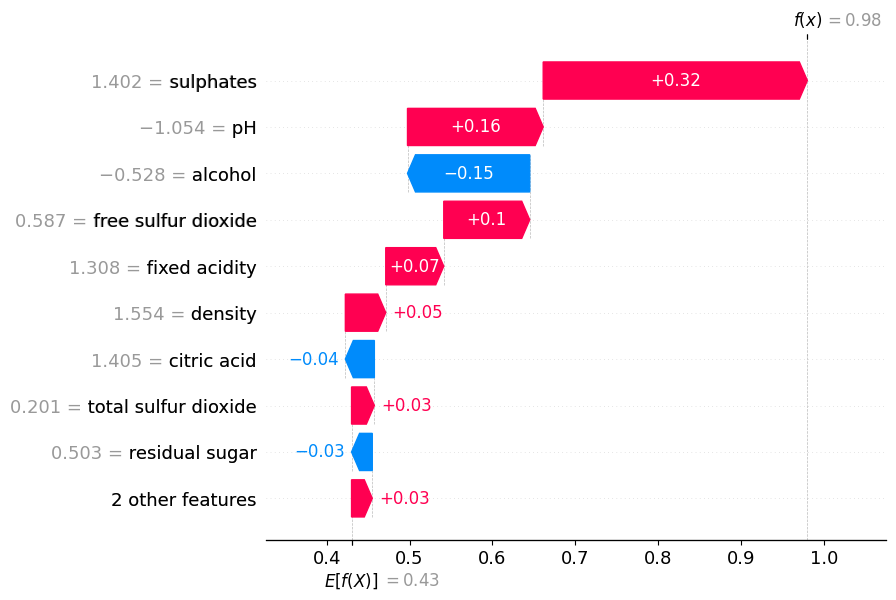

In [246]:
shap.waterfall_plot(shap_explanation[0])


In [230]:
shap.initjs()

shap.force_plot(base_value, shap_values[0], X_test.iloc[0])

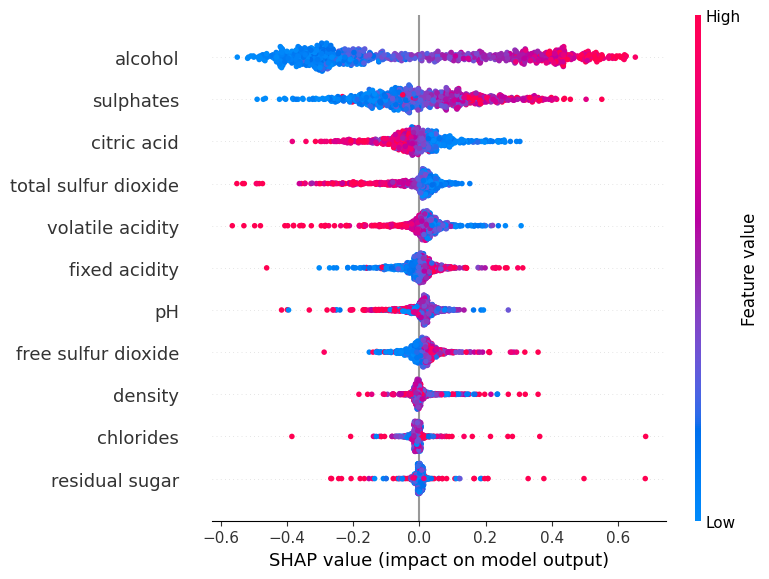

In [231]:
shap.summary_plot(shap_values, X_test)

# Global Interpretation

### Feature Importance

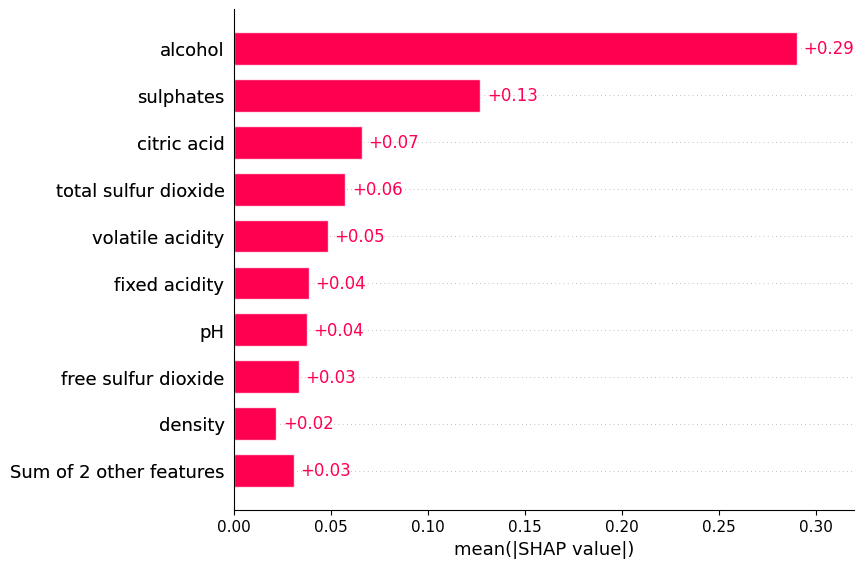

In [257]:
shap.plots.bar(shap_explanation)

In [264]:
sample

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
874,1.308397,-0.844005,0.947371,-0.330202,0.235803,-0.936736,-1.038197,-0.016073,-1.254279,-0.017408,1.229279
235,-0.682382,0.561398,-1.393592,-0.481667,0.111877,-0.174861,-0.249754,0.042293,0.417581,-0.431370,-1.361062
667,1.868304,-1.068869,0.896480,-0.405935,-0.153678,-0.936736,-0.897403,1.130020,-2.458019,0.041730,-1.176038
629,-0.433535,0.870587,-0.223111,-0.178738,0.359729,0.396545,1.045545,-0.143417,-0.652409,-0.253957,-1.083526
831,-1.491136,0.448966,-0.986468,-0.330202,-0.348419,0.015607,-0.643975,-1.544197,1.688195,0.692241,0.581694
...,...,...,...,...,...,...,...,...,...,...,...
686,-0.744594,0.673831,-0.477563,-0.557399,-0.366123,-0.270096,-0.193437,0.174942,0.885702,-0.313095,-1.268550
920,0.810702,-0.675356,0.489356,-0.178738,0.005655,-0.555799,-0.672134,0.631257,-0.451786,-0.549644,0.026621
1353,-0.433535,0.645723,-1.240921,-0.481667,-0.082864,-0.174861,0.285261,0.121883,0.417581,-1.141018,-0.158404
1347,-0.682382,0.701939,-1.240921,-0.557399,-0.224493,-0.841502,-0.981880,-0.424634,0.216958,-1.554980,-0.898501


In [267]:
# define a partition masker that uses our clustering
clustering = shap.utils.hclust(
    sample, y.loc[sample.index]
)
masker = shap.maskers.Partition(sample, clustering=clustering)
explainer = shap.Explainer(svm_model.predict, masker)
sample_test = shap.sample(X_test, 50)

shap_values_partition = explainer(sample_test)

ExactExplainer explainer: 51it [07:09,  8.76s/it]                        


In [268]:
shap_explanation_2 = shap.Explanation(shap_values_partition, base_values=base_value, data=sample_test, feature_names=sample_test.columns)

In [260]:
clustering = shap.utils.hclust(
    X_train, y.iloc[ind_train]
)  # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
shap.plots.bar(shap_explanation, clustering=clustering, clustering_cutoff=0.5)

TypeError: bar() got an unexpected keyword argument 'cluster_threshold'

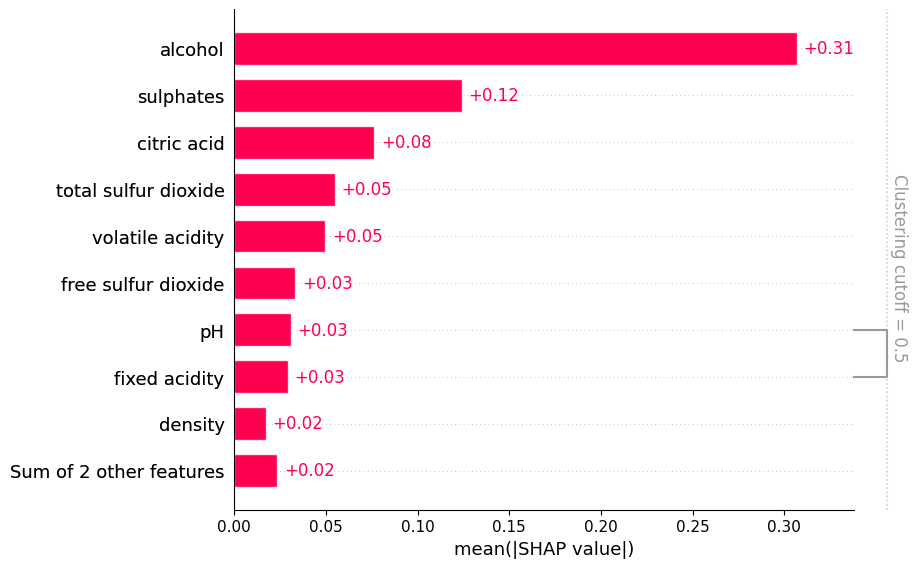

In [278]:
shap.plots.bar(shap_explanation_2, clustering=clustering, clustering_cutoff=0.5)


In [279]:
X_feature_reduction = X_redwine.drop(['fixed acidity'], axis=1)
svm_gs.best_estimator_.fit(X_feature_reduction.iloc[ind_train, :], y.iloc[ind_train])
y_pred_train = svm_gs.best_estimator_.predict(X_feature_reduction.iloc[ind_train, :])
y_true_train = y.iloc[ind_train]
y_pred_val = svm_gs.best_estimator_.predict(X_feature_reduction.iloc[ind_val, :])
y_true_val = y.iloc[ind_val]

y_pred = svm_gs.best_estimator_.predict(X_feature_reduction.iloc[ind_test, :])
y_true = y[ind_test]

acc_train = svm_gs.best_estimator_.score(X_feature_reduction.iloc[ind_train, :], y_true_train)
prec_train = precision_score(y_true_train, y_pred_train, average='weighted')
rec_train = recall_score(y_true_train, y_pred_train, average='weighted')
f1_train = f1_score(y_true_train, y_pred_train, average='weighted')

acc_val = svm_gs.best_estimator_.score(X_feature_reduction.iloc[ind_val, :], y_true_val)
prec_val = precision_score(y_true_val, y_pred_val, average='weighted')
rec_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

acc = svm_gs.best_estimator_.score(X_feature_reduction.iloc[ind_test, :], y_true)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_train, acc_val, acc], 
                        'Precision': [prec_train, prec_val, prec], 
                        'Recall': [rec_train, rec_val, rec],
                        'F1': [f1_train, f1_val, f1]
                       },
                      index=['training', 'validation', 'test'])
cmat = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_)
cmat_norm_true = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='true')
cmat_norm_pred = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='pred')

df_cmat = pd.DataFrame(cmat, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_true = pd.DataFrame(cmat_norm_true, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_pred = pd.DataFrame(cmat_norm_pred, columns=y_nomi_classe, index=y_nomi_classe)

display(df_perf)
display(df_cmat)
display(df_cmat_norm_true)
display(df_cmat_norm_pred)

,Accuracy,Precision,Recall,F1
training,0.82881,0.833746,0.82881,0.828829
validation,0.75000,0.757333,0.75000,0.750107
test,0.73500,0.746316,0.73500,0.734642


,classe 0,classe 1
classe 0,300,70
classe 1,142,288


,classe 0,classe 1
classe 0,0.810811,0.189189
classe 1,0.330233,0.669767


,classe 0,classe 1
classe 0,0.678733,0.195531
classe 1,0.321267,0.804469


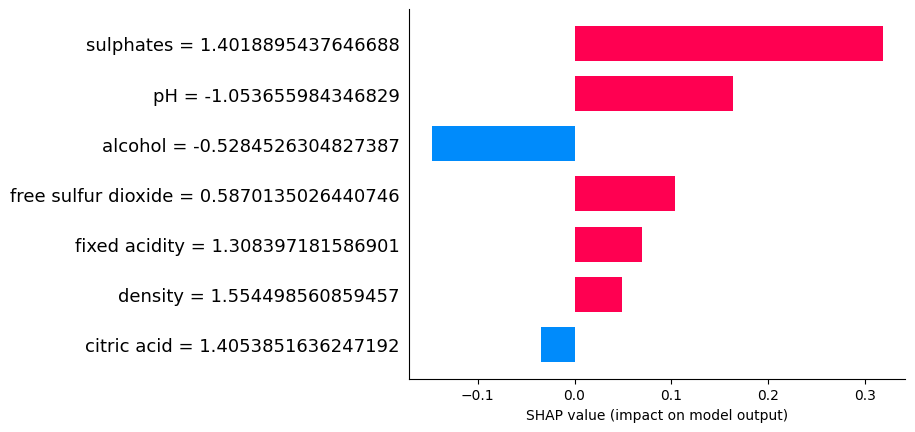

In [242]:
shap.bar_plot(shap_values[0], X_test.iloc[0])

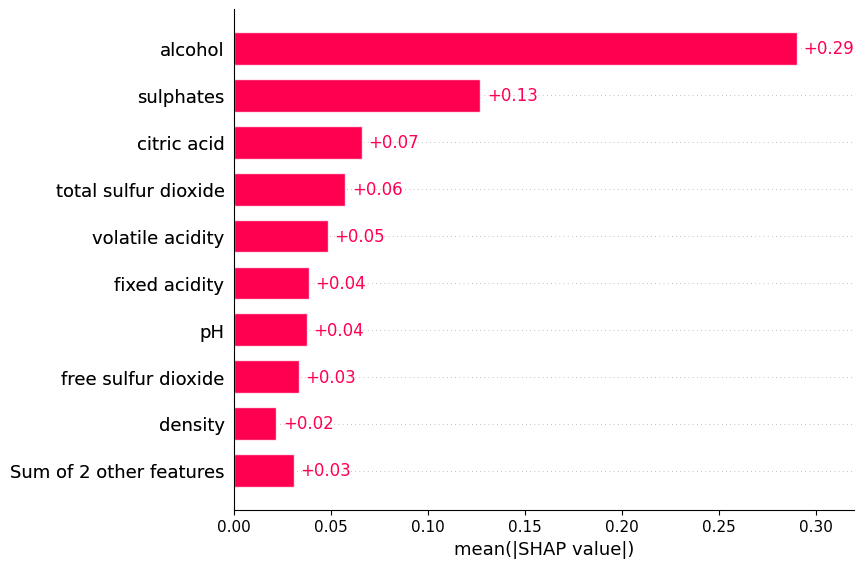

In [227]:
shap.plots.bar(shap_explanation)


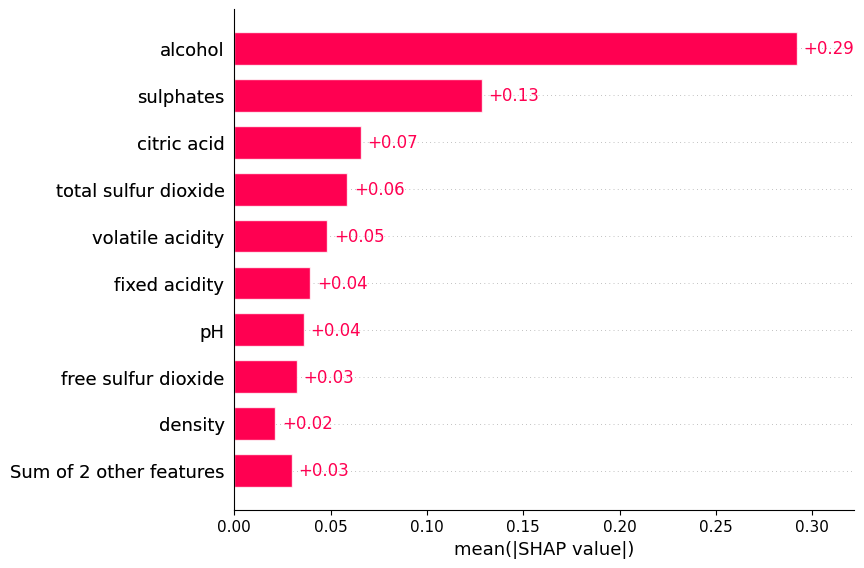

In [195]:
shap.plots.bar(shap_explanation)


In [194]:
shap.initjs()

shap.force_plot(base_value, shap_values[0], X_test.iloc[0])



In [115]:
explanation

.values =
array([[ 0.0175 ,  0.045  , -0.0775 , ..., -0.00125,  0.06875,  0.49375],
       [-0.00875, -0.0025 ,  0.06125, ...,  0.01625, -0.05375, -0.425  ],
       [ 0.07125,  0.0825 , -0.14625, ..., -0.08   ,  0.0125 , -0.40875],
       ...,
       [ 0.03125, -0.03   ,  0.13875, ...,  0.04125,  0.15875,  0.2    ],
       [ 0.01625, -0.01375, -0.02875, ...,  0.01375, -0.04625, -0.28375],
       [ 0.0325 ,  0.01125, -0.16   , ..., -0.05   ,  0.16875, -0.35625]])

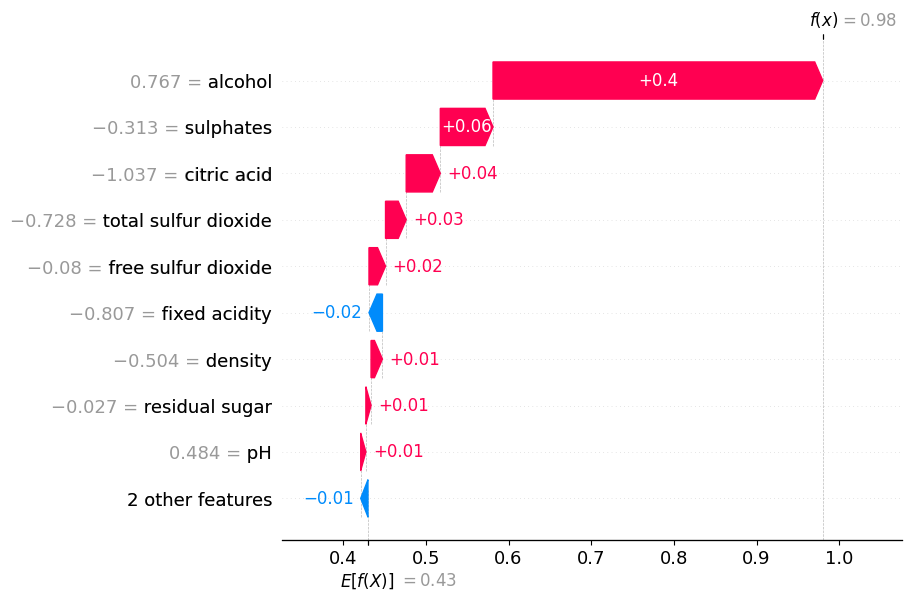

In [208]:
shap_explanation = shap.Explanation(shap_values, base_values=base_value, data=sample, feature_names=sample.columns)
shap.plots.waterfall(shap_explanation[1])

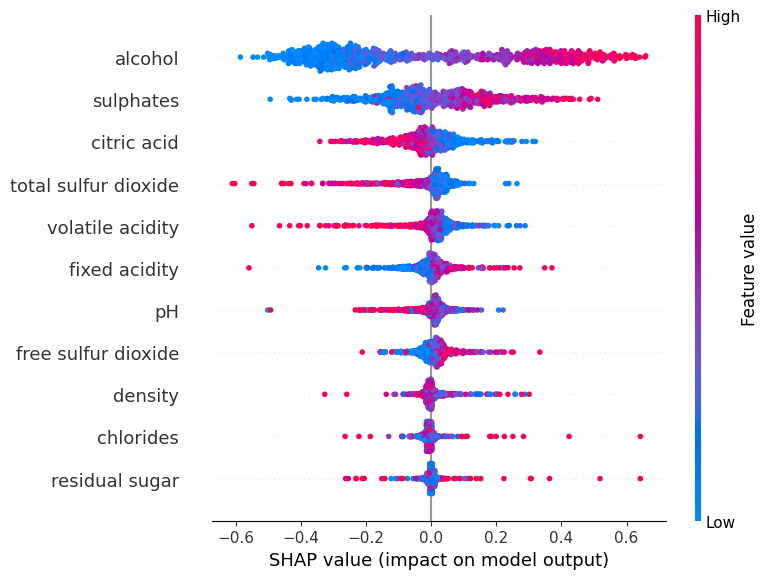

In [209]:
shap.summary_plot(shap_values, scaler.transform(X.iloc[ind_test, :]))

In [204]:
shap_values.shape

(800, 11)

IndexError: index 312 is out of bounds for axis 0 with size 200

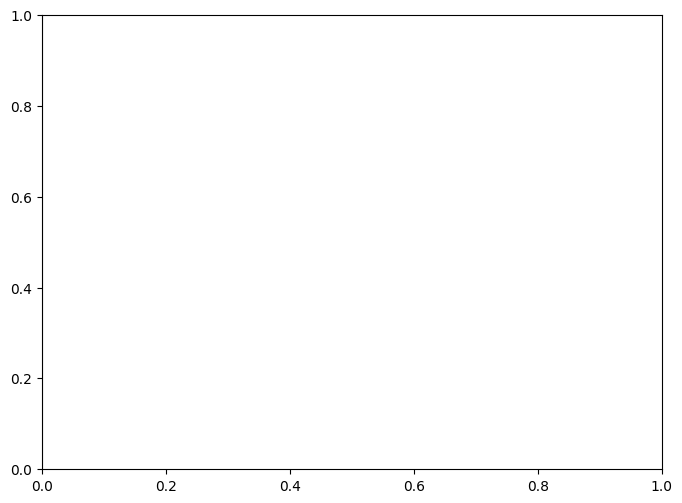

In [207]:
shap.summary_plot(shap_values, )

AssertionError: 'shap_values' and 'features' values must have the same number of rows!

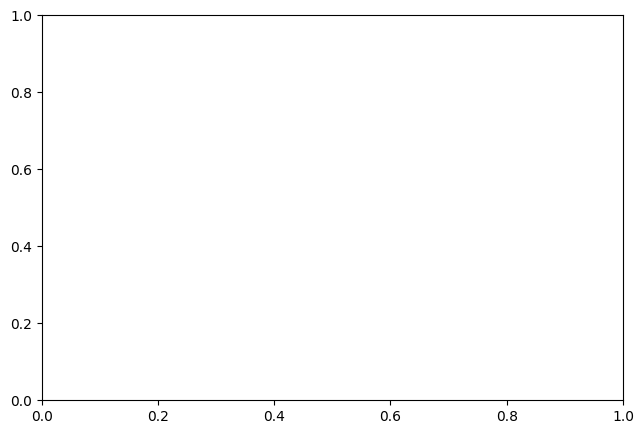

In [202]:
shap.dependence_plot('alcohol', shap_values, sample)


In [184]:
shap_explanation.shape

(100, 11)

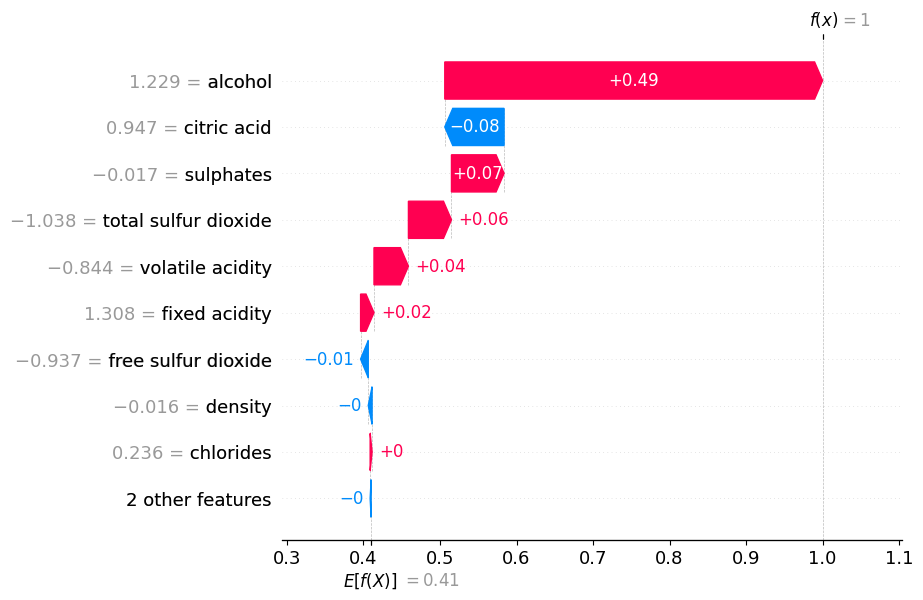

In [135]:
shap.waterfall_plot(shap_explanation[0])


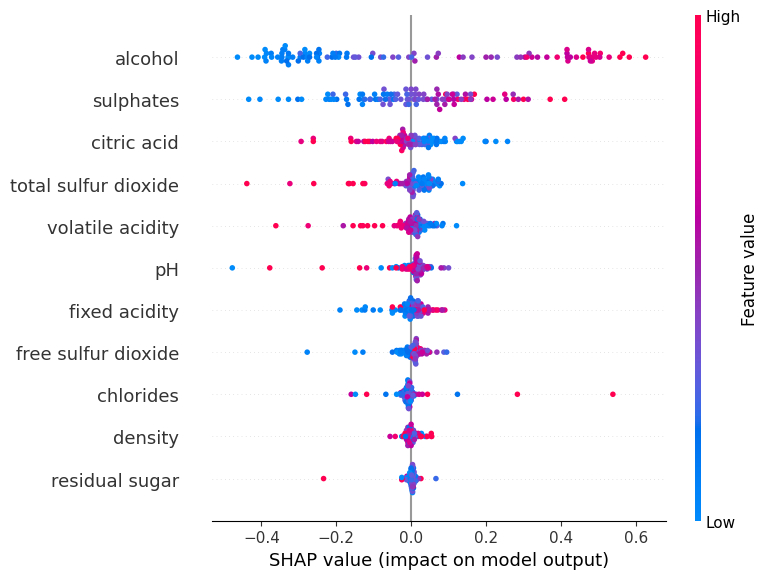

In [125]:
shap.summary_plot(shap_values, sample, show=False)

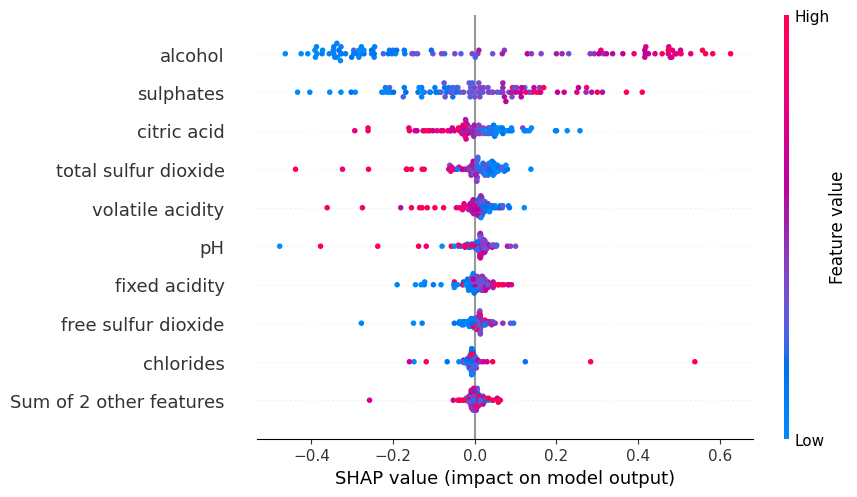

In [128]:
shap.plots.beeswarm(shap_explanation)

In [78]:
explanation = shap.Explanation(shap_values[0], feature_names=sample.columns)


In [79]:
explanation

.values =
array([ 2.2500000e-02,  5.5000000e-02, -5.7500000e-02,  5.0000000e-03,
        6.9388939e-18, -2.0000000e-02,  4.0000000e-02, -1.8750000e-02,
        1.2500000e-03,  8.3750000e-02,  4.7875000e-01])

In [85]:
np.array(shap_values[0]).shape

(11,)

In [83]:
#shap.waterfall_plot(shap_values, sample, show=False)
explanation = shap.Explanation(shap_values[0], feature_names=sample.columns)
shap.plots.waterfall(shap_values[0])


TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

.values =
array([[ 3.12500000e-02,  1.25000000e-02, -9.37500000e-02,
         0.00000000e+00, -6.25000000e-03,  0.00000000e+00,
         4.37500000e-02, -6.25000000e-03, -1.38777878e-17,
         6.25000000e-03,  4.62500000e-01],
       [-3.75000000e-02, -6.25000000e-03,  8.12500000e-02,
         0.00000000e+00, -6.25000000e-03,  6.25000000e-03,
        -6.25000000e-03, -6.25000000e-03,  1.25000000e-02,
        -6.25000000e-02, -5.25000000e-01],
       [ 9.37500000e-02,  1.87500000e-02, -1.31250000e-01,
         0.00000000e+00, -6.25000000e-03, -4.37500000e-02,
         3.75000000e-02,  6.25000000e-03, -5.00000000e-02,
         2.50000000e-02, -5.00000000e-01],
       [ 6.25000000e-03, -1.25000000e-02, -6.25000000e-03,
         0.00000000e+00,  6.25000000e-03,  0.00000000e+00,
        -7.50000000e-02, -1.25000000e-02,  1.87500000e-02,
        -3.12500000e-02, -4.43750000e-01],
       [-8.75000000e-02, -1.25000000e-02,  4.37500000e-02,
         6.25000000e-03, -6.25000000e-03, -6.938893

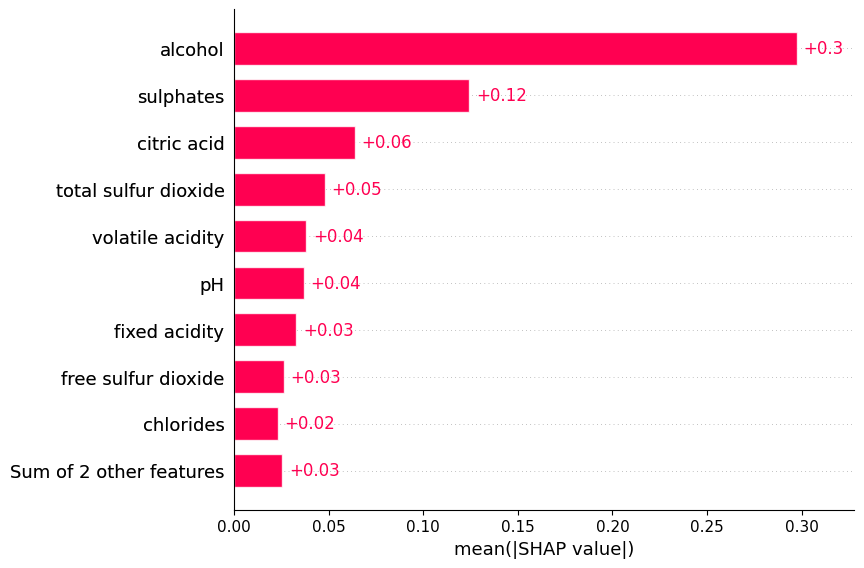

In [74]:
explanation = shap.Explanation(shap_values, feature_names=sample.columns)
shap.plots.bar(explanation)

In [24]:
best_model = svm_gs.best_estimator_.fit(X.iloc[ind_train, :].values, y.iloc[ind_train].values)

sample = shap.sample(X_redwine.iloc[ind_train], 20)

# Use the KernelExplainer with the best model
explainer = shap.KernelExplainer(best_model.predict, sample)
shap_values = explainer.shap_values(sample)


  0%|          | 0/20 [00:00<?, ?it/s]

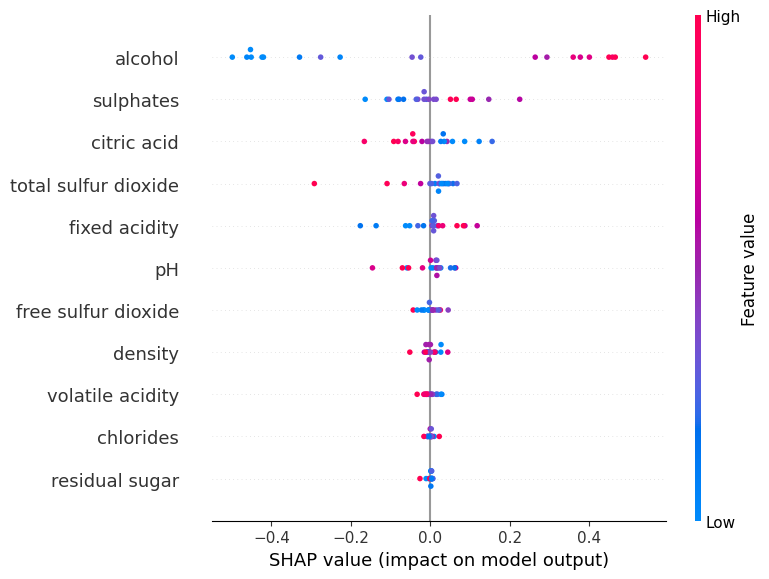

In [25]:
shap.summary_plot(shap_values, sample, show=False)

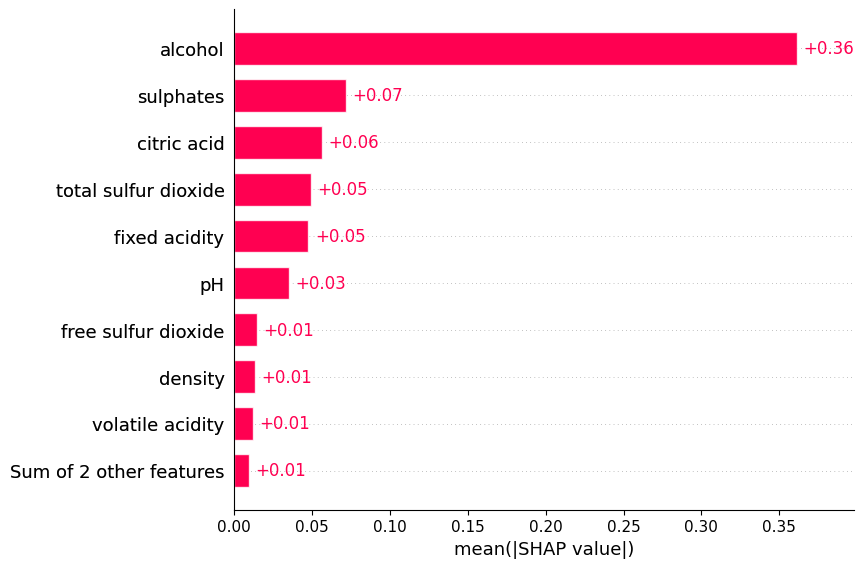

array([ 3.10533911e-02,  1.45057720e-02, -8.13077201e-02, -4.34704185e-04,
        2.87878788e-03, -1.50577201e-02,  4.30176768e-02, -4.81962482e-03,
        1.92640693e-03,  8.47402597e-03,  4.49763709e-01])

In [26]:
explanation = shap.Explanation(shap_values, feature_names=sample.columns)
shap.plots.bar(explanation)
display(shap_values[0])

In [159]:
explainer = shap.PermutationExplainer(best_model.predict, sample)


In [160]:
shap_values = explainer.shap_values(sample)

X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted 

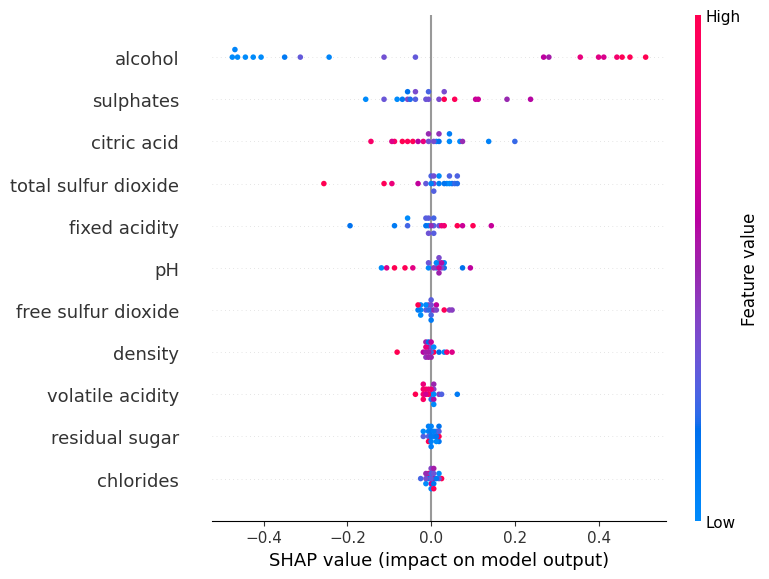

In [161]:
shap.summary_plot(shap_values, sample, show=False)

In [ ]:
X_copy = red_wine_copy.drop('quality', axis=1)
X_test = X_copy.iloc[ind_test]
y_copy = red_wine_copy['quality']
y_test = y_copy.iloc[ind_test]


In [ ]:
X_test

In [62]:
scaler = StandardScaler()
scaler.fit(X_copy.iloc[ind_train], y_copy.iloc[ind_train])
X_trans = scaler.transform(X_copy.iloc[ind_train])
svm = SVC(class_weight='balanced', probability=True, kernel='rbf', gamma=0.090909, C=2)
svm.fit(X_trans,y_copy.iloc[ind_train])
sample = shap.sample(X_copy.iloc[ind_train], 20)
sample_trans = scaler.transform(sample)
svm_explainer = shap.KernelExplainer(svm.predict,sample_trans)
svm_shap_values = svm_explainer.shap_values(sample_trans)
shap.summary_plot(svm_shap_values, sample_trans, feature_names=X_copy.columns,show=False)

NameError: name 'X_copy' is not defined

In [ ]:
sample = shap.sample(X_copy.iloc[ind_test], 20)
sample_trans = scaler.transform(sample)
svm_shap_values_train = svm_explainer.shap_values(sample_trans)
shap.summary_plot(svm_shap_values_train, sample_trans, feature_names=X_copy.columns,show=False)

In [ ]:
svm = SVC(class_weight='balanced', probability=True, kernel='rbf', gamma=0.090909, C=2)
svm.fit(X_copy.iloc[ind_train],y_copy.iloc[ind_train])
sample = shap.sample(X_copy.iloc[ind_train], 20)
svm_explainer = shap.KernelExplainer(svm.predict,sample)
svm_shap_values_test = svm_explainer.shap_values(sample)
shap.summary_plot(svm_shap_values_test, sample, show=False)

In [76]:
from sklearn.preprocessing import StandardScaler
import shap

n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]), verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])

sample = shap.sample(X_redwine.iloc[ind_train], 20)

# Use the KernelExplainer with the best model
explainer = shap.KernelExplainer(best_model.predict, sample)
shap_values = explainer.shap_values(sample)


Fitting 1 folds for each of 60 candidates, totalling 60 fits


  0%|          | 0/20 [00:00<?, ?it/s]

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

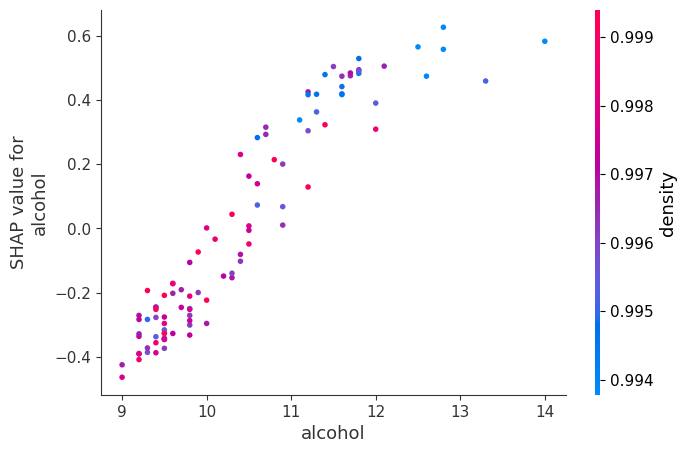

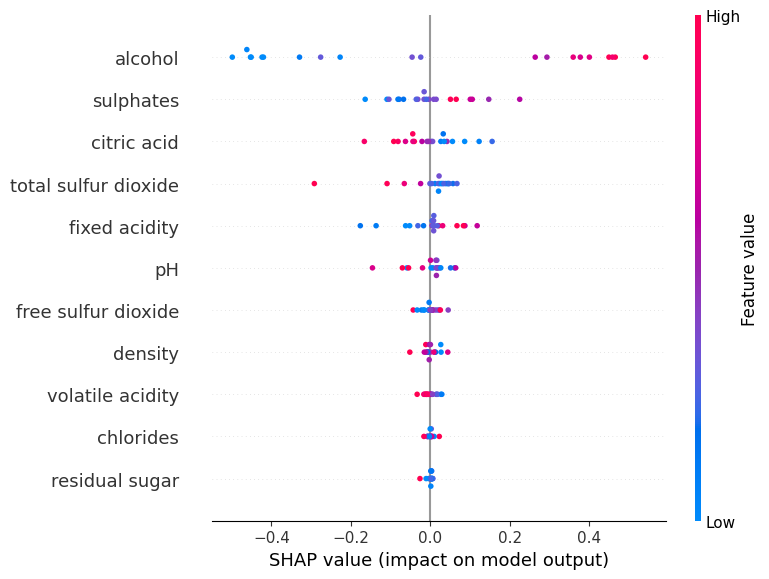

In [77]:
shap.summary_plot(shap_values, sample, show=False)

In [ ]:
X_copy.iloc[ind_train]

In [ ]:
X[ind_train]

In [ ]:
from sklearn.preprocessing import StandardScaler
import shap

n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]), verbose=True)

svm_gs.fit(X, y)

sample = shap.sample(X[ind_train], 20)

best_model = svm_gs.best_estimator_
scaler = best_model.named_steps['scaler']
scaler.fit(X[ind_train])
scaled_sample = scaler.transform(sample) 

svm_model = best_model.named_steps['svc']
svm_model.fit(scaled_sample, y[ind_train])


# Get the SVM model from the pipeline
# svm_model = best_model[-1]

sample = shap.sample(X[ind_train], 20)

# Inverse transform the validation data
scaler = best_model.named_steps['scaler']

# inv_sample = scaler.inverse_transform(sample)

# X_val_inverse = scaler.inverse_transform(X[ind_val])
scaled_sample = scaler.transform(sample) 
# Use the KernelExplainer with the best model
explainer = shap.KernelExplainer(best_model.predict, scaled_sample)
shap_values = explainer.shap_values(scaled_sample)

# for i, c in enumerate(sample.columns):
#    shap_values.output_names[i] = c

shap_values.data = sample

In [ ]:
shap.summary_plot(shap_values, sample, show=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
import shap

n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]), verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])


X_copy = red_wine_copy.drop('quality', axis=1)
# Get the SVM model from the pipeline
svm_model = best_model.named_steps['svc']
# svm_model = best_model[-1]

sample = shap.sample(X_copy.iloc[ind_train], 20)

# Inverse transform the validation data
scaler = best_model.named_steps['scaler']

# inv_sample = scaler.inverse_transform(sample)

# X_val_inverse = scaler.inverse_transform(X[ind_val])
scaled_sample = scaler.transform(sample) 
# Use the KernelExplainer with the best model
explainer = shap.KernelExplainer(best_model.predict, scaled_sample)
shap_values = explainer.shap_values(scaled_sample)

for i, c in enumerate(sample.columns):
    shap_values.output_names[i] = c

shap_values.data = sample.values

In [ ]:
shap.summary_plot(shap_values, sample, show=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
import shap

n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]), verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])


X_copy = red_wine_copy.drop('quality', axis=1)
# Get the SVM model from the pipeline
svm_model = best_model.named_steps['svc']
# svm_model = best_model[-1]

sample = shap.sample(X_copy.iloc[ind_train], 100)

# Inverse transform the validation data
scaler = best_model.named_steps['scaler']

inv_sample = scaler.inverse_transform(sample)

# X_val_inverse = scaler.inverse_transform(X[ind_val])

# Use the KernelExplainer with the best model
explainer = shap.KernelExplainer(best_model.predict, sample)
shap_values = explainer.shap_values(sample)
shap_values.data = sample


In [ ]:
shap.summary_plot(shap_values, sample, show=False)

In [ ]:
n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]),verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])
best_model = best_model.inverse_transform
X_copy = red_wine_copy.drop('quality', axis=1)
# Get the SVM model from the pipeline
svm_model = best_model.named_steps['svc']
# svm_model = best_model[-1]

sample = shap.sample(X_copy.iloc[ind_train], 20)
# Create the shap.KernelExplainer using the SVM model and the training data
explainer = shap.KernelExplainer(svm_model.predict, sample)

# Generate SHAP values for a sample of the dataset
X_test = X_copy.iloc[ind_test]
y_test = red_wine_copy['quality']
y_test = y_test.iloc[ind_test]

from sklearn.model_selection import StratifiedShuffleSplit




# sample = X_copy.iloc[test_indices, :]  # assuming X is a pandas DataFrame
shap_values = explainer.shap_values(sample)
# shap_obj = explainer(sample)
# shap_obj = explainer(sample)
# shap_exp = shap.Explanation(sample.values, shap_values, feature_names=sample.columns)
# Visualize the SHAP values

#
# shap.summary_plot(shap_values = np.take(shap_obj.values,0,axis=1),features = sample, feature_names = sample.columns)

In [ ]:
shap.summary_plot(shap_values, sample, show=False)

In [ ]:
shap.dependence_plot("alcohol", shap_values, sample)


In [ ]:
"""n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]),verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])

X_copy = red_wine_copy.drop('quality', axis=1)
# Get the SVM model from the pipeline
svm_model = best_model.named_steps['svc']

sample = shap.sample(X_copy.iloc[ind_test], 50)
# Create the shap.KernelExplainer using the SVM model and the training data
explainer = shap.KernelExplainer(svm_model.predict_proba, sample)

# Generate SHAP values for a sample of the dataset
X_test = X_copy.iloc[ind_test]
y_test = red_wine_copy['quality']
y_test = y_test.iloc[ind_test]

from sklearn.model_selection import StratifiedShuffleSplit

# Split the test set using stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)
test_indices = next(sss.split(X_test, y_test))[1]


# sample = X_copy.iloc[test_indices, :]  # assuming X is a pandas DataFrame
shap_values = explainer.shap_values(sample)
# shap_obj = explainer(sample)
shap_exp = shap.Explanation(sample.values, shap_values, feature_names=sample.columns)
# Visualize the SHAP values
shap.plots.beeswarm(shap_exp)"""

In [ ]:
"""n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]),verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])

X_copy = red_wine_copy.drop('quality', axis=1)
# Get the SVM model from the pipeline
svm_model = best_model.named_steps['svc']

# Create the shap.KernelExplainer using the SVM model and the training data
explainer = shap.KernelExplainer(svm_model.predict_proba, X_copy.iloc[ind_train, :])

# Generate SHAP values for a sample of the dataset
X_test = X_copy.iloc[ind_test]
y_test = red_wine_copy['quality']
y_test = y_test.iloc[ind_test]

from sklearn.model_selection import StratifiedShuffleSplit

# Split the test set using stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)
test_indices = next(sss.split(X_test, y_test))[1]


sample = X_copy.iloc[test_indices, :]  # assuming X is a pandas DataFrame
shap_values = explainer.shap_values(sample)

# Visualize the SHAP values
shap.summary_plot(shap_values, sample)"""

In [ ]:
n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(class_weight='balanced'))])
hparameters = {'svc__kernel':ker_list, 'svc__C':C_list, 'svc__gamma':gamma_list}

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]),verbose=True)
svm_gs.fit(X, y)

In [ ]:
df_results = pd.DataFrame(svm_gs.cv_results_)

display(df_results.sort_values(['rank_test_score'], ascending=True))

In [ ]:
# Calcolo delle predizioni sul test set.
# Nomi delle variabili:
#
# y_pred_train: vettore delle predizioni sul training;
# y_true_train: vettore dei target "veri" del training set;
# y_pred_val: vettore delle predizioni sul validation;
# y_true_val: vettore dei target "veri" del validation set;
#
# y_pred: vettore delle predizioni sul test;
# y_true: vettore dei target "veri" del test set

# Ri-addestramento della miglior SVM
svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])

y_pred_train = svm_gs.best_estimator_.predict(X[ind_train, :])
y_true_train = y[ind_train]
y_pred_val = svm_gs.best_estimator_.predict(X[ind_val, :])
y_true_val = y[ind_val]

y_pred = svm_gs.best_estimator_.predict(X[ind_test, :])
y_true = y[ind_test]

acc_train = svm_gs.best_estimator_.score(X[ind_train, :], y_true_train)
prec_train = precision_score(y_true_train, y_pred_train, average='weighted')
rec_train = recall_score(y_true_train, y_pred_train, average='weighted')
f1_train = f1_score(y_true_train, y_pred_train, average='weighted')

acc_val = svm_gs.best_estimator_.score(X[ind_val, :], y_true_val)
prec_val = precision_score(y_true_val, y_pred_val, average='weighted')
rec_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

acc = svm_gs.best_estimator_.score(X[ind_test, :], y_true)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_train, acc_val, acc], 
                        'Precision': [prec_train, prec_val, prec], 
                        'Recall': [rec_train, rec_val, rec],
                        'F1': [f1_train, f1_val, f1]
                       },
                      index=['training', 'validation', 'test'])
cmat = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_)
cmat_norm_true = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='true')
cmat_norm_pred = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='pred')

df_cmat = pd.DataFrame(cmat, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_true = pd.DataFrame(cmat_norm_true, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_pred = pd.DataFrame(cmat_norm_pred, columns=y_nomi_classe, index=y_nomi_classe)

display(df_perf)
display(df_cmat)
display(df_cmat_norm_true)
display(df_cmat_norm_pred)

In [ ]:
M1, N1 = red_wine.loc[ind_train+1, ['quality']].shape
M2, N2 = red_wine.loc[ind_test+1, ['quality']].shape
M3, N3 = red_wine.loc[ind_test+1, ['quality']].shape

class_cont_freq_tr = pd.concat([red_wine.loc[ind_train+1, ['quality']].value_counts(), red_wine.loc[ind_train+1, ['quality']].value_counts()/M1], axis=1)
class_cont_freq_tr.columns = ['counts', 'freq.']  
class_cont_freq_tr.index.names = ['class']
class_cont_freq_tr.sort_values('class', inplace=True)

class_cont_freq_te = pd.concat([red_wine.loc[ind_test+1, ['quality']].value_counts(), red_wine.loc[ind_test+1, ['quality']].value_counts()/M2], axis=1)
class_cont_freq_te.columns = ['counts', 'freq.']  
class_cont_freq_te.index.names = ['class']
class_cont_freq_te.sort_values('class', inplace=True)

class_cont_freq_va = pd.concat([red_wine.loc[ind_val+1, ['quality']].value_counts(), red_wine.loc[ind_val+1, ['quality']].value_counts()/M3], axis=1)
class_cont_freq_va.columns = ['counts', 'freq.']  
class_cont_freq_va.index.names = ['class']
class_cont_freq_va.sort_values('class', inplace=True)

display(class_cont_freq_tr)
display(class_cont_freq_te)
display(class_cont_freq_va)
